<img src=https://api-manager.universia.net/coreplatform-document-management/api/document-management/public/6ra7ymjkfi64845 width="300" align="left">
<br />

# Aprendizaje automático I
#### <font color=green>*Máster en Informática Industrial y Robótica*</font>

Daniel Vidal Soroa  
Juan Diego Peña 

## Clasificación de mangos en tres clases según su presencia para la exportación, comercio local o procesamiento industrial

#### Importación de las librerías:

In [1]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from keras.models import Sequential, Model
from keras.applications import vgg16, mobilenet, resnet, xception
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from random import seed
from random import randint
from keras import layers
import seaborn as sns

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical")
])

# Función para mostrar lista de imágenes en escala de grises
def show_row_of_gray_images(fig_width, *images):
    plt.figure(figsize=(fig_width, fig_width))
    images_count = len(images)
    index = 1  
    for image in images:
        plt.subplot(1, images_count, index)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        index+=1

# Función para añadir datos a una tebla de excel
def append_data_to_excel(excel_name, df):
    with pd.ExcelWriter(excel_name,
        mode="a",
        engine="openpyxl",
        if_sheet_exists="overlay") as writer:
        start_row = 0
        header = True
        if os.path.exists(excel_name):
            df_source = pd.read_excel(excel_name, engine="openpyxl").iloc[:,1:]
        if df_source is not None:
            n, m = df_source.shape
            header = False if n > 0 else True
            start_row = n + 1 if n > 0 else n
        
        df.to_excel(writer, sheet_name="Sheet1",startcol=0, startrow = start_row, header=header)

# Función para graficar progreso durante el entrenamiento de la red 
def plot_history(history):
    plt.figure(figsize=(12,5))
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label = 'Validación')
    plt.xlabel('Iteración (epoch)')
    plt.ylabel('Exactitud (accuracy)')
    plt.ylim([0, 1])
    plt.grid()
    plt.title('Modelo '+str(i+1))
    plt.legend(loc='lower right')

#Distintas arquitectura para salida de la red neuronal
def cnn1(_input_shape, classes):
    model = Sequential()
    model.add(Flatten(input_shape=_input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(classes, activation='softmax'))   
    return model

def cnn2(_input_shape, classes):
    model = Sequential()
    model.add(Flatten(input_shape=_input_shape))
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(classes, activation='softmax'))
    return model

def cnn3(_input_shape, classes):
    model = Sequential()
    model.add(Flatten(input_shape=_input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(classes, activation='softmax'))
    return model

def get_base_model(name,input_size):
    if name == 'vgg':
        return vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(input_size,input_size,3))
    elif name == 'mobilnet':
        return mobilenet.MobileNet(include_top=False, weights='imagenet', input_shape=(input_size,input_size,3))
    elif name == 'xception':
        return xception.Xception(include_top=False, weights='imagenet', input_shape=(input_size,input_size,3))
    else: return resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(input_size,input_size,3))


#### Lectura de los datos:

850
759
461


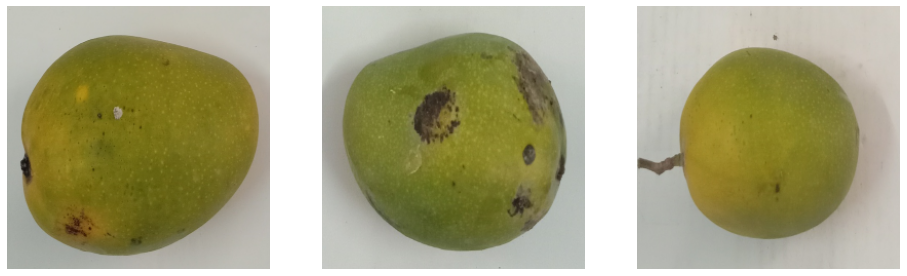

In [2]:
# seed random number generator
seed(1)

# Dimensión de entrada de las imágenes 
IMG_SIZE = 256
h = IMG_SIZE
w = IMG_SIZE

# Leer los nombres de las imágenes para importarlas
input_class1_path = "./Dataset/Grading_dataset/Class_I"
class1_names = os.listdir(input_class1_path)
input_class2_path = "./Dataset/Grading_dataset/Class_II"
class2_names = os.listdir(input_class2_path)
input_classex_path = "./Dataset/Grading_dataset/Extra_Class"
class3_names = os.listdir(input_classex_path)

# Número de elementos en cada clase
n = len(class1_names)

# Definir listas para cargar imágenes
class1 = np.ones([n, h, w, 3])
class2 = np.ones([n, h, w, 3])
class3 = np.ones([n, h, w, 3])

for i in range(0, n, 1):
    # Para cada clase, se lee una imágen, se importa
    img = resize(imread("./Dataset/Grading_dataset/Class_I/" + class1_names[i]), (h, w))
    class1[i] = img  
    img = resize(imread("./Dataset/Grading_dataset/Class_II/" + class2_names[i]), (h, w))
    class2[i] = img 
    img = resize(imread("./Dataset/Grading_dataset/Extra_Class/" + class3_names[i]), (h, w))
    class3[i] = img 

# Aumentamos por un factor f el número de datos de cada clase
f = 5
class1_augmeted = np.zeros([n * f, h, w, 3])
class2_augmeted = np.zeros([n * f, h, w, 3])
class3_augmeted = np.zeros([n * f, h, w, 3])
t1 = np.zeros(n * f)
t2 = np.zeros(n * f)
t3 = np.zeros(n * f)

for i in range(n * f):
    rn = randint(0, n-1)
    img = class1[rn]
    new_img = data_augmentation(img)
    class1_augmeted [i] = new_img
    t1[i] = 1
    
    rn = randint(0, n-1)
    img = class2[rn]
    new_img = data_augmentation(img)
    class2_augmeted [i] = new_img
    t2[i] = 2
    
    rn = randint(0, n-1)
    img = class3[rn]
    new_img = data_augmentation(img)
    class3_augmeted [i] = new_img
    t3[i] = 0

# Se imprimen tres imágenes aleatorias de los datos aumentados para comprobar que funciona    
limit1 = len(class1_augmeted)
rn = randint(0, limit1 - 1)
img_1 = class1_augmeted[rn]
print (rn)

limit2 = len(class2_augmeted)
rn = randint(0, limit2 - 1)
img_2 = class2_augmeted[rn]
print (rn)

limit3 = len(class3_augmeted)
rn = randint(0, limit3 - 1)
img_3 = class3_augmeted[rn]  
print (rn)

show_row_of_gray_images(16, img_1, img_2, img_3)

# Se define el conjunto de datos de entrenamiento
X = np.concatenate((class3_augmeted, class1_augmeted, class2_augmeted), axis = 0)

# Se definen las etiquetas de las clases
t = np.concatenate((t3, t1, t2), axis = 0)

X_train_val, X_test, t_train_val, t_test = train_test_split(X, t, test_size=0.3,shuffle=True)
X_train, X_val, t_train, t_val = train_test_split(X_train_val, t_train_val, test_size=0.3, shuffle=True)
train_target = tf.keras.utils.to_categorical(t_train)
val_target = tf.keras.utils.to_categorical(t_val)
test_target = tf.keras.utils.to_categorical(t_test)


In [3]:
encoder = Sequential([
    layers.Conv2D(input_shape=(IMG_SIZE,IMG_SIZE,3), filters= 27, kernel_size = (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(9, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D( (2, 2), padding='same'),
    layers.Conv2D(3, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D( (2, 2), padding='same')
])

pretrain_encodings = encoder(X_train).numpy()
print(pretrain_encodings.shape)

decoder = Sequential ([
    layers.UpSampling2D((2, 2), input_shape = pretrain_encodings[0].shape),
    layers.Conv2D(9, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(27, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(3, (3, 3), padding='same') 
])

autoencoder_dr = Model(inputs = encoder.inputs, outputs = decoder(encoder.outputs))
autoencoder_dr.compile(loss = 'mse')
autoencoder_dr.fit(X_train, X_train, epochs = 10, verbose=1)

ResourceExhaustedError: Exception encountered when calling layer "conv2d" (type Conv2D).

OOM when allocating tensor with shape[1470,256,256,27] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Conv2D]

Call arguments received:
  • inputs=tf.Tensor(shape=(1470, 256, 256, 3), dtype=float32)

#### Se importa la red CNN VGG16 para utilizar su arquitectura y conocimento para resolver nuestro problema 

In [9]:
# include top should be False to remove the softmax layer
model_name = "vgg"
pretrained_model = get_base_model(model_name,32)
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [10]:
classes = 3
input_shape = pretrained_model.output_shape[1:4]
modelCNN = cnn1(input_shape, classes)
# compile the model
modelCNN.compile(optimizer='adam', metrics=['accuracy',
                                            tf.keras.metrics.Recall(),
                                            tf.keras.metrics.TrueNegatives(),
                                            tf.keras.metrics.FalsePositives(), 
                                            tf.keras.metrics.Precision(),
                                            tf.keras.metrics.AUC()], loss='categorical_crossentropy')
modelCNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 33,027
Trainable params: 33,027
Non-trainable params: 0
_________________________________________________________________


#### Finalmente se realiza la clasificación utilizando las capas finales de la red

In [11]:
# train model using features generated from VGG16 model
epochs = 300
batch_size = 50
specificity = []
train_time = []
eval_time = []
precision = []
accuracy = []
f1_score = []
au_curve = []
_layers = []
params = []
recall = []
model = []
batch = []
epoch = []
time_ = []

posttrain_encodings = encoder(X_train).numpy()
posttrain_val = encoder(X_val).numpy()
#Se entrena el modelo
tic = time.perf_counter()
features_train = pretrained_model.predict(posttrain_encodings)
features_val = pretrained_model.predict(posttrain_val)

ValueError: Data cardinality is ambiguous:
  x sizes: 1000
  y sizes: 1
Make sure all arrays contain the same number of samples.

In [12]:
history = (modelCNN.fit(features_train, train_target, epochs=epochs, batch_size=batch_size, validation_data=(features_val, val_target)))
toc = time.perf_counter()
train_time.append(round((toc-tic), 2))

# Se evalua el modelo segun algunas metricas de error
tic = time.perf_counter()
features_test = pretrained_model.predict(X_test.reshape(len(X_test),IMG_SIZE,IMG_SIZE,3))
test_loss, test_acc, test_recall, true_neg, false_pos, test_prec, test_auc = modelCNN.evaluate(features_test,  test_target, verbose=0)
toc = time.perf_counter()
eval_time.append(round((toc-tic), 2))
specificity.append(round(true_neg/(true_neg + false_pos),2))
f1_score.append(round(2 * test_recall * test_prec / (test_recall + test_prec),2)
                if (test_recall + test_prec) > 0 else 0)
model.append(pretrained_model.name)
epoch.append(epochs)
batch.append(batch_size)
accuracy.append(round(test_acc,2))
recall.append(round(test_recall,2))
precision.append(round(test_prec,2))
au_curve.append(round(test_auc,2))
_layers.append(len(modelCNN.layers))
params.append(modelCNN.count_params()) 

test_data = {'base model':model,
        'out layers': _layers,
        'extra params': params,
        'epochs': epoch,
        'batch size': batch,
        'accuracy': accuracy,
        'recall': recall,
        'specificity': specificity,
        'precision': precision,
        'f1_score': f1_score,
        'auc': au_curve,
        'train time': train_time,
        'eval time': eval_time
        }

now = datetime.now() # current date and time
time_.append(now.strftime("%d/%m/%Y %H:%M:%S"))
df = pd.DataFrame(test_data, index = time_)
excel_name = "./informe/tables/DCNN.xlsx"
append_data_to_excel(excel_name, df)
print(df)
plot_history(history)


KeyboardInterrupt



#### Se puede calcular la matriz de confusión de la red

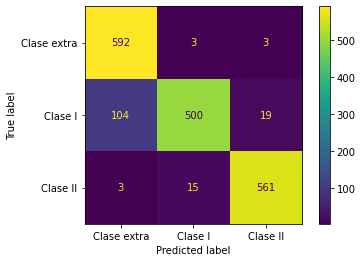

In [38]:
Clases=['Clase extra','Clase I','Clase II']
features_test = pretrained_model.predict(X_test.reshape(len(X_test),IMG_SIZE,IMG_SIZE,3))
t_pred = []
for i in range(0,len(features_test)):
    t_pred.append(np.argmax(modelCNN.predict(features_test[i:i+1])))
cm = confusion_matrix(t_test, t_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=Clases)
disp.plot()

In [37]:

stored_accuracy = history.history['accuracy'][-5:]

%store stored_accuracy

Stored 'stored_accuracy' (list)
